<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span><ul class="toc-item"><li><span><a href="#Import-Stuff" data-toc-modified-id="Import-Stuff-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import Stuff</a></span></li><li><span><a href="#Some-Anonymous-Functions" data-toc-modified-id="Some-Anonymous-Functions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Some Anonymous Functions</a></span></li><li><span><a href="#Named-Functions" data-toc-modified-id="Named-Functions-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Named Functions</a></span></li><li><span><a href="#Clean-Data" data-toc-modified-id="Clean-Data-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Clean Data</a></span></li></ul></li><li><span><a href="#Main-Body" data-toc-modified-id="Main-Body-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Main Body</a></span><ul class="toc-item"><li><span><a href="#Look-at-Distribution-of-Individual-and-Total-Dipole" data-toc-modified-id="Look-at-Distribution-of-Individual-and-Total-Dipole-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Look at Distribution of Individual and Total Dipole</a></span></li><li><span><a href="#Total-vs-Individual" data-toc-modified-id="Total-vs-Individual-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Total vs Individual</a></span></li><li><span><a href="#Ferro-vs-Antiferro" data-toc-modified-id="Ferro-vs-Antiferro-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Ferro vs Antiferro</a></span></li><li><span><a href="#Compare-Potential-Maps" data-toc-modified-id="Compare-Potential-Maps-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Compare Potential Maps</a></span><ul class="toc-item"><li><span><a href="#Collect-Data" data-toc-modified-id="Collect-Data-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Collect Data</a></span><ul class="toc-item"><li><span><a href="#Need-to-add-the-energies-for-the-new-potential-map.-Did-not-originally-collect" data-toc-modified-id="Need-to-add-the-energies-for-the-new-potential-map.-Did-not-originally-collect-2.4.1.1"><span class="toc-item-num">2.4.1.1&nbsp;&nbsp;</span>Need to add the energies for the new potential map. Did not originally collect</a></span></li></ul></li><li><span><a href="#Compare-Maps" data-toc-modified-id="Compare-Maps-2.4.2"><span class="toc-item-num">2.4.2&nbsp;&nbsp;</span>Compare Maps</a></span></li></ul></li></ul></li></ul></div>

# Setup

## Import Stuff

In [43]:
import pickle as pkl
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as GS
import numpy as np
import seaborn as sns

sns.set()

try:
    with open("tidy_data/pc_vaccum_upto_75_data.pkl","rb") as file_in:
        raw_data = pkl.load(file_in)
        print("Pickled data sucessfully loaded.")
        raw_df = pd.DataFrame(raw_data)
except:
    print("Error loading data.")

raw_df.head()

Pickled data sucessfully loaded.


,config,couple,dipoles,fill,run,total_dipole
0,40,antiferro,"[111.813436184817, 42.03248288794034, 45.32547...",1110,17,5.646604
1,1,antiferro,"[47.00603262068403, 42.295300104326785, 50.764...",1110,11,0.616420
2,34,ferro,[2.8570597419216925],1000,21,2.857060
3,39,antiferro,"[83.77401049958284, 85.98770391558408]",1010,23,0.764843
4,18,ferro,[33.56415220017746],1000,21,33.564152


## Some Anonymous Functions

In [5]:
filter_by_fill = lambda fill,df: df[df.fill == fill]
filter_by_couple = (lambda couple,df: df[df.couple == couple]
                    .sort_values(["config","run"],axis=0))
                   # .set_index(["config"]))
filter_by_config = lambda config,df: df[df.config == config]

flatten = lambda x: [j for i in x for j in i]
get_dipoles = lambda df: flatten(df.dipoles.values)
get_total_dipole = lambda df: df.total_dipole.values

drop_outliers = lambda df: df.drop(df.index[return_outliers(total_dipole)])

## Named Functions

In [6]:
def reject_outliers(data, m = 1.):
        '''Used modified Z-score itl.nist.gov/div898/handbook/eda/section3/eda35h.htm '''
        data = np.array(data)
        d = np.abs(data - np.median(data))
        mdev = np.median(d)
        s = d/mdev if mdev else 0.
        return data[s<m]
    
def return_outliers(data, m = 1.0):
    '''Used modified Z-score itl.nist.gov/div898/handbook/eda/section3/eda35h.htm '''
    data = np.array(data)
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    reject = list(data[s>=m])
    return [list(data).index(i) for i in reject]


def get_fill_df(couple,fill,m=1.0):   
    entries = []
    for config in list(set(raw_df.config.values)):
        
        try:
            df = filter_by_config(config,filter_by_couple(couple,filter_by_fill(fill,raw_df)))
            dipoles = get_dipoles(df)
            total_dipole = get_total_dipole(df)
            df = drop_outliers(df)
            clean_dipoles = get_dipoles(df)
            clean_total_dipole = get_total_dipole(df)

            entry = {'couple':couple, 'fill':fill, 'config':config, 
                     'raw_dipoles':dipoles,'clean_dipoles':clean_dipoles,
                     'raw_total_dipole':total_dipole,'clean_total_dipole':clean_total_dipole}

            entries.append(entry)
        except:
            print("Error: {} {} {} ".format(couple,fill,config))
        
    return pd.DataFrame(entries)

def plot_dipole_distribution_fill(couple=None,fill=None,ax=None):
    df = get_fill_df(couple,fill,m=1.0)
    plt.title("Fill: {}  Couple: {}".format(fill,couple.upper()))
    sns.distplot(flatten(df.clean_total_dipole.values),label="Total Dipole"); 
    sns.distplot(flatten(df.clean_dipoles.values),label="Dipole");
    ax.legend();
    ax.set(xlabel="Dipole [Debye]",ylabel="Count [a.u.]",xlim=[-25,100]);
    
def plot_dipole_distribution_couple(type_=None,fill=None,ax=None):
    
    type_dict = {'total':'clean_total_dipole', 'indiv':'clean_dipoles'}
    try:
        ty = type_dict[type_]
    except:
        print("Invalid type. Use 'total' or 'indiv'")
        return
    plt.title("Fill: {}  Type: {}".format(fill,ty.upper()))
    f_df = get_fill_df("ferro",fill,m=1.0)
    sns.distplot(flatten(f_df[ty].values),label="Ferro");
    if fill != 1000:
        a_df = get_fill_df("antiferro",fill,m=1.0)
        sns.distplot(flatten(a_df[ty].values),label="Antiferro"); 
    
    ax.legend();
    if type_ == "total":
        ax.set(xlabel="Dipole [Debye]",ylabel="Count [a.u.]",xlim=[-5,15]);
    else:
        ax.set(xlabel="Dipole [Debye]",ylabel="Count [a.u.]",xlim=[-25,125]);
        

def make_total_individual_plot(m=1.):
    fills = set(raw_df.fill.values)
    couples = set(raw_df.couple.values)
    types= "total indiv".split()
    #fills.sort()

    gs = GS.GridSpec(5,2);
    fig = plt.figure(figsize=(16,16));


    for row,fill in enumerate(fills):
        for col,type_ in enumerate(types):
            ax = fig.add_subplot(gs[row,col]);
            fig.subplots_adjust(hspace=0.5)
            plot_dipole_distribution_couple(type_=type_,fill=fill,ax=ax)
            

def make_fill_couple_plot():
    fills = set(raw_df.fill.values)
    couples = set(raw_df.couple.values)


    gs = GS.GridSpec(4,2);
    fig = plt.figure(figsize=(16,16));


    for row,fill in enumerate(fills):
        for col,couple in enumerate(couples):
            if not ((fill == 1000) and (couple == "antiferro")): # DNE
                ax = fig.add_subplot(gs[row,col]);
                fig.subplots_adjust(hspace=0.5)
                plot_dipole_distribution_fill(couple=couple,fill=fill,ax=ax)

## Clean Data

In [66]:
for col in ["config","fill","run"]:
    raw_df[col] = raw_df[col].apply(int)



# For some reasons, this needs to run first. Need to debug why. I think it has something
# to do with the passing of m between functions
config = 0
couple="ferro"
fill=1000
df = filter_by_config(config,filter_by_couple(couple,filter_by_fill(fill,raw_df)))

total_dipole = get_total_dipole(df) # This specifically has to be called

# Main Body

## Look at Distribution of Individual and Total Dipole

## Total vs Individual

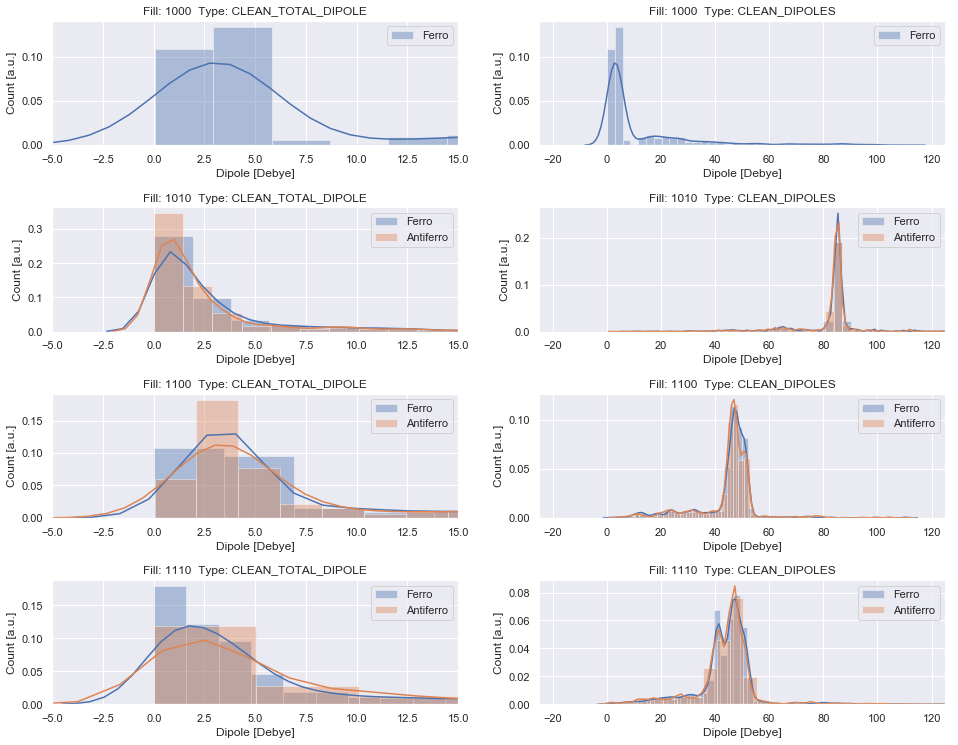

In [8]:
make_total_individual_plot()

## Ferro vs Antiferro

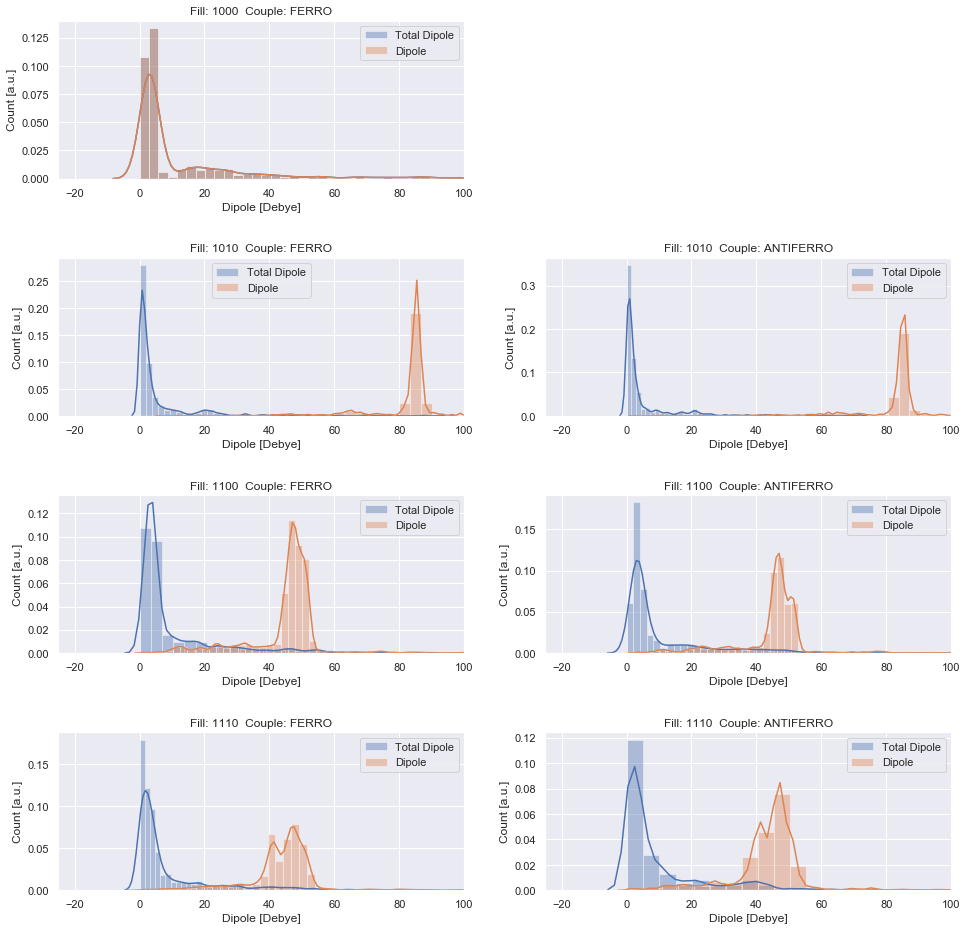

In [6]:
make_fill_couple_plot()


## Compare Potential Maps

### Collect Data

In [87]:
path = "../../potential_map/broad_sweep/tidy_data/pmap_antiferro_1110.pkl"
with open(path,"rb") as file_in:
    orig_df = pkl.load(file_in)
    

orig_df = orig_df.sort_values("config")
new_df = filter_by_fill(1010,raw_df).sort_values("config")
new_df = filter_by_couple("antiferro",new_df[new_df.run == 0])



#### Need to add the energies for the new potential map. Did not originally collect

In [101]:
new_en = pkl.load(open("tidy_data/pc_antiferro_1110_energy.pkl","rb"))
new_en_df = pd.DataFrame(new_en)
new_en_df.config = new_en_df.config.apply(int)

new_en_df = new_en_df.sort_values("config",axis=0)
new_en_df.head()


,config,energy
0,0,-42.731164
11,1,-42.731164
22,2,-42.731164
33,3,-42.731164
44,4,-42.731165


In [136]:
new_df["angle"] = new_df.config.values*0.6/60
orig_df["angle"] = orig_df.config.values*np.pi/3/100

### Compare Maps

In [149]:
def plot_map(df=None,ax=None):
    sns.lineplot(x="angle",y="energy",data=df,ax=ax)
    
def zero_energy(df):
    zero_en = df.energy.values[0]
    df.energy -= zero_en
    return df

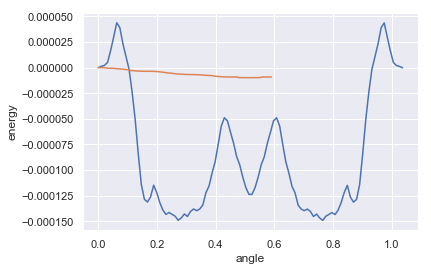

In [156]:

plot_map(zero_energy(orig_df))
plot_map(zero_energy(new_df))

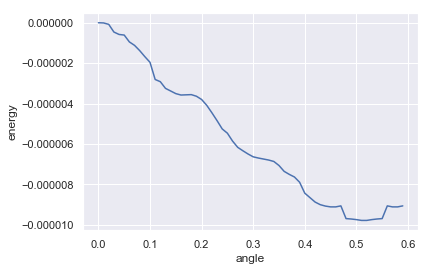

In [157]:
plot_map(zero_energy(new_df))